In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import os

sns.set_style('dark')

%load_ext autotime
%matplotlib inline

FILE = "PGE.csv"
DIRI = "data"
MIN_K = 3
MAX_K = 25 # Assigned because of practicality

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.99 ms


In [4]:
file_path = os.path.join(DIRI, FILE)
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_time             43848 non-null  object
 1   raw demand (MW)       43848 non-null  object
 2   category              43848 non-null  object
 3   cleaned demand (MW)   43848 non-null  int64 
 4   forecast demand (MW)  43848 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
time: 131 ms


In [5]:
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW)
0,2015-07-02 00:00:00,MISSING,MISSING,2740,MISSING
1,2015-07-02 01:00:00,MISSING,MISSING,3287,MISSING
2,2015-07-02 02:00:00,MISSING,MISSING,3264,MISSING
3,2015-07-02 03:00:00,MISSING,MISSING,3192,MISSING
4,2015-07-02 04:00:00,MISSING,MISSING,3136,MISSING
...,...,...,...,...,...
43843,2020-07-01 19:00:00,2315,OKAY,2315,2359
43844,2020-07-01 20:00:00,2337,OKAY,2337,2392
43845,2020-07-01 21:00:00,2325,OKAY,2325,2391
43846,2020-07-01 22:00:00,2308,OKAY,2308,2390


time: 31.7 ms


In [6]:
# Convert the date string to a pandas datetime
df["date_time"] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df["date"] = df["date_time"].dt.date  # Add separate date string 
df["hour"] = df["date_time"].dt.hour  # Add separate hour string
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW),date,hour
0,2015-07-02 00:00:00,MISSING,MISSING,2740,MISSING,2015-07-02,0
1,2015-07-02 01:00:00,MISSING,MISSING,3287,MISSING,2015-07-02,1
2,2015-07-02 02:00:00,MISSING,MISSING,3264,MISSING,2015-07-02,2
3,2015-07-02 03:00:00,MISSING,MISSING,3192,MISSING,2015-07-02,3
4,2015-07-02 04:00:00,MISSING,MISSING,3136,MISSING,2015-07-02,4
...,...,...,...,...,...,...,...
43843,2020-07-01 19:00:00,2315,OKAY,2315,2359,2020-07-01,19
43844,2020-07-01 20:00:00,2337,OKAY,2337,2392,2020-07-01,20
43845,2020-07-01 21:00:00,2325,OKAY,2325,2391,2020-07-01,21
43846,2020-07-01 22:00:00,2308,OKAY,2308,2390,2020-07-01,22


time: 94.4 ms


In [7]:
# Drop all columns except "Cleaned Demand (MW)"
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)", "date_time"], axis=1)
df_demand = df_dropped.pivot(index = "date", columns = "hour", values = "cleaned demand (MW)").copy()
df_demand

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,2740,3287,3264,3192,3136,2974,2773,2515,2271,2121,...,2232,2421,2602,2763,2900,3026,3161,3191,3306,3363
2015-07-03,3445,3443,3410,3308,3225,3072,2807,2567,2329,2137,...,2038,2196,2349,2509,2650,2797,2892,2935,3024,3116
2015-07-04,3177,3169,3223,3093,3040,2926,2748,2485,2254,2080,...,1903,1996,2136,2276,2414,2568,2669,2720,2795,2853
2015-07-05,2852,2901,2870,2780,2690,2589,2473,2275,2127,1971,...,1780,1877,2041,2115,2320,2407,2510,2642,2702,2769
2015-07-06,2832,2880,2942,2842,2850,2702,2527,2301,2073,1933,...,2099,2247,2392,2598,2712,2839,2950,3026,3145,3158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,3145,3190,3111,2959,2790,2673,2491,2274,2061,1909,...,1763,1865,1978,2091,2145,2196,2221,2230,2227,2216
2020-06-28,2244,2282,2257,2200,2144,2122,2028,1879,1737,1662,...,1618,1703,1835,1946,2033,2077,2113,2129,2118,2105
2020-06-29,2152,2220,2250,2224,2184,2153,2035,1868,1737,1650,...,1914,2070,2175,2241,2297,2329,2358,2358,2376,2399


time: 67.3 ms



k =  3 
Magnitude =  1331106044.7382557 
Sizes =  [328, 666, 833] 
Silhouetten Score =  0.34846035619396504 
Davies-Bouldin Score =  1.0602976917096736

k =  4 
Magnitude =  1123305273.9634826 
Sizes =  [634, 259, 547, 387] 
Silhouetten Score =  0.2737841752162796 
Davies-Bouldin Score =  1.1524862069152886

k =  5 
Magnitude =  951893655.2042692 
Sizes =  [625, 507, 328, 233, 134] 
Silhouetten Score =  0.29218874131579525 
Davies-Bouldin Score =  1.082583151693854

k =  6 
Magnitude =  811054363.3971176 
Sizes =  [576, 117, 374, 301, 279, 180] 
Silhouetten Score =  0.30715746364082547 
Davies-Bouldin Score =  1.0812869145471067

k =  7 
Magnitude =  726480109.6736853 
Sizes =  [110, 288, 285, 251, 532, 275, 86] 
Silhouetten Score =  0.29357017219457193 
Davies-Bouldin Score =  1.0589803223883998

k =  8 
Magnitude =  656913489.1293207 
Sizes =  [76, 163, 244, 242, 302, 472, 261, 67] 
Silhouetten Score =  0.29334177999562006 
Davies-Bouldin Score =  1.0305874824032824

k =  9 
Magnitu

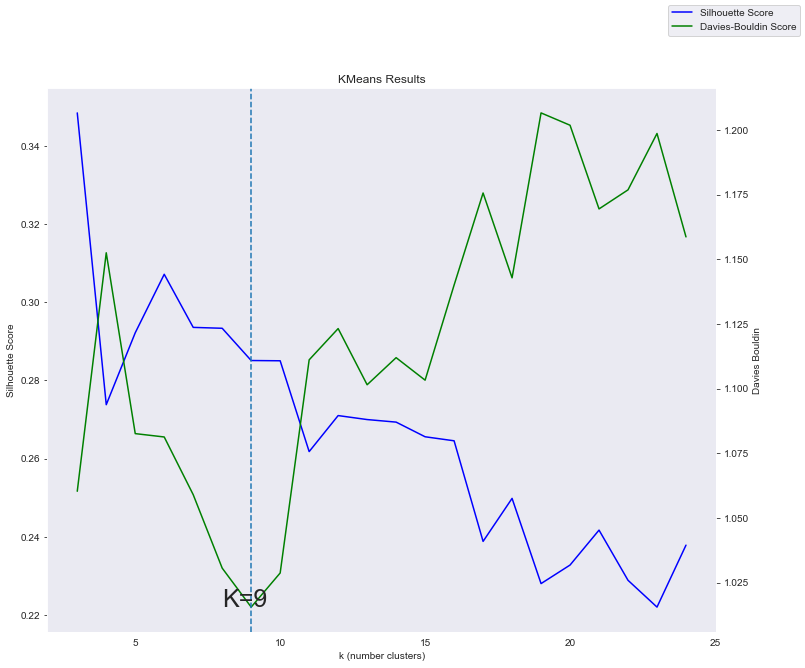

time: 11 s


In [37]:
# Save cluster magnitudes (sum of sqaured distances to the centroid) in a dataframe
# where index = number of clusters
#

# .inertia_ returns the sum of squared distances of samples to their closest cluster center
# .cluster_centers_  returns array wuth coordinates of cluster centers
# .labels_ returns the cluster label of each example in order

cluster_stats = pd.DataFrame(index=range(MIN_K, MAX_K), columns=["Magnitude", "Silhouette", "DB"])

for k in cluster_stats.index:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_demand)
    clusters = kmeans.labels_
    cluster_stats["Magnitude"][k] = kmeans.inertia_
    
    # For each cluster label, find how many examples are part of that cluster
    cluster_sizes = []
    for i in range(k):
        cluster_sizes.append(len(np.where(clusters == i)[0]))

    # Calculate the average Silhouette Score for each cluster
    cluster_stats['Silhouette'][k] = silhouette_score(df_demand, kmeans.labels_)

    # Davies Boulding score
    cluster_stats['DB'][k] = davies_bouldin_score(df_demand, kmeans.labels_)
    
    print("\nk = ", k,
     "\nMagnitude = ", kmeans.inertia_,
     "\nSizes = ", cluster_sizes, 
     "\nSilhouetten Score = ", cluster_stats['Silhouette'][k], 
     "\nDavies-Bouldin Score = ", cluster_stats['DB'][k])
    

fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title("KMeans Results")
ax.plot(cluster_stats['Silhouette'], color='blue', label='Silhouette Score')
ax.set_xlabel("k (number clusters)")
ax.set_ylabel("Silhouette Score")

ax2 = ax.twinx()
ax2.plot(cluster_stats['DB'], color='green', label='Davies-Bouldin Score')
ax2.set_ylabel('Davies Bouldin')

ax2.axvline(x=MIN_K+np.argmin(cluster_stats['DB']), linestyle='--')
ax2.text(MIN_K+np.argmin(cluster_stats['DB'])-1,
 np.min(cluster_stats['DB']),
 f"K={MIN_K+np.argmin(cluster_stats['DB'])}", 
 fontsize=25)

fig.legend()

fig.savefig(f"silhouette_graphs/kmeans_results")

C:\Users\jimpg\AppData\Local\Temp/ipykernel_18460/3604848054.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  avg_silho = pd.Series(index=range(3, MAX_K))


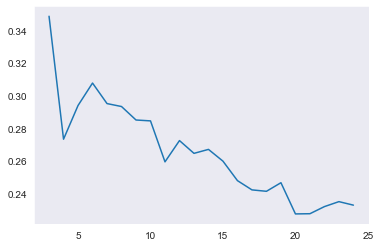

time: 19.5 s


In [9]:
# Perform silhouette analysis on a point-by-point basis
avg_silho = pd.Series(index=range(3, MAX_K))

for k in range(3, MAX_K):
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(df_demand)

    silhouette_avg = silhouette_score(df_demand, cluster_labels)
    sample_silhouette_values = silhouette_samples(df_demand, cluster_labels)

    avg_silho[k] = silhouette_avg

    y_lower = 10
    for i in range(k): # for each cluster created
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples


    plt.title(f"Silhouette Coefficients for All Points, k={k}")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.savefig(f"silhouette_graphs/kmeans_silhouette_{k}.png")
    plt.close()

plt.plot(avg_silho)

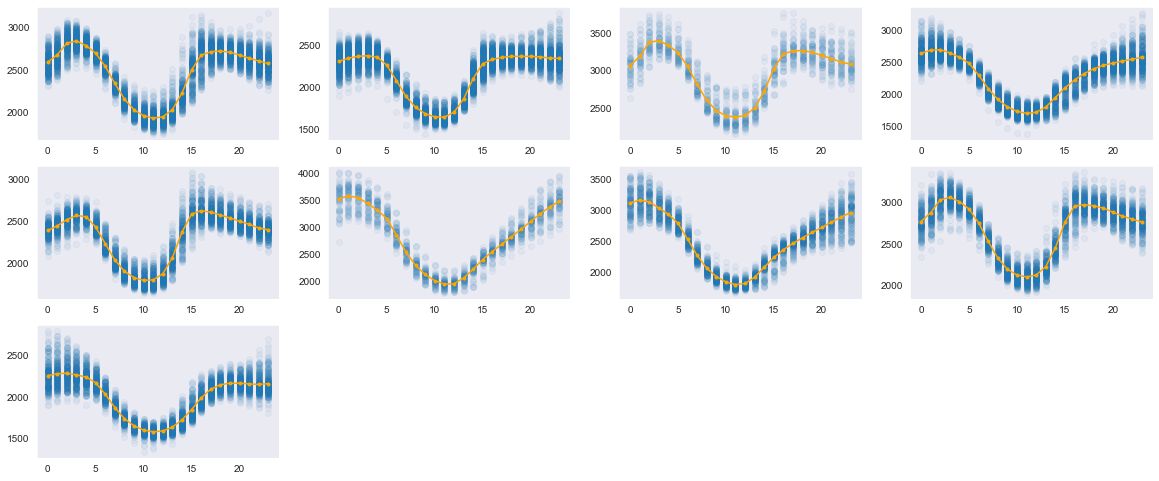

time: 3.55 s


In [36]:
from matplotlib.gridspec import GridSpec

chosen_k = 9

fig = plt.figure(figsize=(20, 20))
gs = GridSpec(MAX_K//4 + 1, 4, figure=fig)

kmeans = KMeans(n_clusters=chosen_k, random_state=0).fit(df_demand)
clusters = kmeans.labels_
df_demand["profile_cluster"] = clusters

centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids = centroids.T

for k in range(chosen_k):
    df_cluster_loads = df_demand.loc[df_demand["profile_cluster"] == k].reset_index()
    df_cluster_loads.drop("profile_cluster", axis=1, inplace=True)
    df_cluster_loads = df_cluster_loads.melt(id_vars="date")
    ax = fig.add_subplot(gs[k])
    ax.scatter(df_cluster_loads["hour"], df_cluster_loads["value"], alpha=0.05)
    ax.plot(centroids[k][0:24], '.-', color='orange')

fig.savefig(f'silhouette_graphs/kmeans_{chosen_k}_load_profiles')

Let's figure out what kind of day each cluster represents.

In [11]:
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)"], axis=1)
df_date = df_dropped.pivot(index = "date", columns = "hour", values = ["cleaned demand (MW)", "date_time"])
df_date.columns

for i in range(1, 24):
    df_date.drop(('date_time', i), axis=1, inplace=True)
df_date.columns

MultiIndex([('cleaned demand (MW)',  0),
            ('cleaned demand (MW)',  1),
            ('cleaned demand (MW)',  2),
            ('cleaned demand (MW)',  3),
            ('cleaned demand (MW)',  4),
            ('cleaned demand (MW)',  5),
            ('cleaned demand (MW)',  6),
            ('cleaned demand (MW)',  7),
            ('cleaned demand (MW)',  8),
            ('cleaned demand (MW)',  9),
            ('cleaned demand (MW)', 10),
            ('cleaned demand (MW)', 11),
            ('cleaned demand (MW)', 12),
            ('cleaned demand (MW)', 13),
            ('cleaned demand (MW)', 14),
            ('cleaned demand (MW)', 15),
            ('cleaned demand (MW)', 16),
            ('cleaned demand (MW)', 17),
            ('cleaned demand (MW)', 18),
            ('cleaned demand (MW)', 19),
            ('cleaned demand (MW)', 20),
            ('cleaned demand (MW)', 21),
            ('cleaned demand (MW)', 22),
            ('cleaned demand (MW)', 23),
            (   

time: 669 ms


In [12]:
def is_weekday(x):
    if x < 5:
        return True
    else:
        return False
    
    
def season_name(x):
    if x == 1:
        return "Winter"
    if x == 2:
        return "Spring"
    if x == 3:
        return "Summer"
    if x == 4:
        return "Fall"

time: 1.02 ms


In [13]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
df_date["weekday"] = df_date[("date_time", 0)].dt.dayofweek
df_date["season num"] = df_date[("date_time", 0)].dt.month%12 // 3 + 1
df_date["cluster"] = kmeans.labels_

df_date["is weekday"] = df_date["weekday"].apply(lambda x: is_weekday(x))
df_date["season"] = df_date["season num"].apply(lambda x: season_name(x))

df_clusters = df_date[["cluster", "is weekday", "season"]]
df_clusters.columns = ["cluster", "is weekday", "season"]

for k in range(MAX_K):
    dfk = df_clusters.loc[df_clusters["cluster"] == k]
    print(dfk.value_counts())

cluster  is weekday  season
0        True        Fall      93
                     Summer    78
                     Spring    33
         False       Fall      11
                     Spring     6
                     Winter     5
         True        Winter     3
dtype: int64
cluster  is weekday  season
1        True        Summer    64
         False       Summer    13
         True        Fall       6
         False       Fall       3
                     Winter     1
         True        Spring     1
dtype: int64
cluster  is weekday  season
2        True        Spring    132
                     Fall       83
                     Summer     58
         False       Spring     30
                     Fall       13
                     Winter      1
dtype: int64
cluster  is weekday  season
3        True        Winter    117
         False       Winter     15
         True        Fall        8
                     Spring      8
         False       Fall        1
dtype: int64
cluster  

In [14]:
def cluster_similarity(x, centroid):
    # input is all rows belonging to a cluster
    total = 0
    
    for row in range(len(x)):
        for hour in range(23):
            total += abs(x[hour][row] - centroid[hour])
    
    return total/len(x)

time: 1.02 ms


In [15]:
centroids.columns

RangeIndex(start=0, stop=12, step=1)

time: 2.98 ms


In [16]:
cluster_sims = []
for k in range(MAX_K - 2):    
    input_x = dfp.loc[kmeans.labels_ == k].reset_index()
    cluster_sims.append(cluster_similarity(input_x, centroids[k]))
    print(f"\nCluster {k}:", cluster_sims[k])

NameError: name 'dfp' is not defined

time: 18.1 ms


(array([7., 5., 4., 9., 9., 4., 5., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([24576.3902439 , 26304.19726232, 28032.00428074, 29759.81129915,
        31487.61831757, 33215.42533599, 34943.23235441, 36671.03937282,
        38398.84639124, 40126.65340966, 41854.46042807, 43582.26744649,
        45310.07446491, 47037.88148333, 48765.68850174, 50493.49552016,
        52221.30253858, 53949.10955699, 55676.91657541, 57404.72359383,
        59132.53061224]),
 <BarContainer object of 20 artists>)

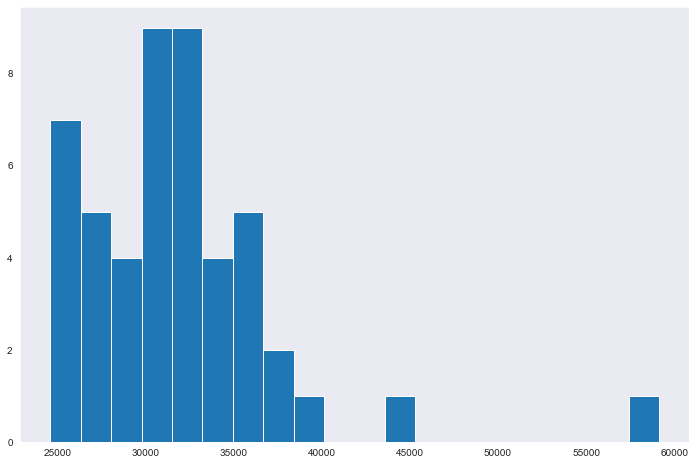

time: 106 ms


In [ ]:
plt.figure(figsize = (12, 8))
plt.hist(cluster_sims, bins = 20)

In [ ]:
# dset used to represent cluster for everyday over dataset
dset = df_clusters.copy()
dset["date_time"] = df_date[("date_time", 0)]
dset["year"] = dset["date_time"].dt.year
dset["day"] = dset["date_time"].dt.dayofyear
dset = dset.reset_index()
dset = dset.melt(id_vars=["year", "day"])
dset = dset.loc[dset["variable"] == "cluster"]
dset.drop("variable", axis=1, inplace=True)
dset.rename(columns = {"value":"cluster"}, inplace=True)
dset = dset.pivot(index="year", columns="day", values="cluster")
dset

day,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,28,37,11,28,4,12,12,12,NaN
2016,24,24,24,2,41,39,46,12,4,18,...,2,29,28,37,11,4,12,12,46,24
2017,28,28,26,41,15,15,16,15,15,2,...,24,24,42,2,15,16,15,41,41,NaN
2018,16,16,16,16,16,16,8,2,2,2,...,24,24,13,31,4,4,12,42,24,NaN
2019,28,18,2,46,42,24,30,4,18,39,...,30,24,35,5,28,28,37,19,42,NaN
2020,24,30,4,24,24,20,46,2,46,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 27.4 ms


In [ ]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
# NOTE: Monday = 0
def day_type_calc(season, weekday):
    # Weekdays
    if weekday:
        return season
    # Weekends
    else:
        return season + 4
    
df_clusters

,cluster,is weekday,season,date_time,year,day,day type
date,,,,,,,
2015-07-02,48,True,Summer,2015-07-02,2015,183,Summer Weekday
2015-07-03,17,True,Summer,2015-07-03,2015,184,Summer Weekday
2015-07-04,33,False,Summer,2015-07-04,2015,185,Summer Weekend
2015-07-05,33,False,Summer,2015-07-05,2015,186,Summer Weekend
2015-07-06,27,True,Summer,2015-07-06,2015,187,Summer Weekday
...,...,...,...,...,...,...,...
2020-06-27,10,False,Summer,2020-06-27,2020,179,Summer Weekend
2020-06-28,10,False,Summer,2020-06-28,2020,180,Summer Weekend
2020-06-29,27,True,Summer,2020-06-29,2020,181,Summer Weekday


time: 9 ms


In [ ]:
df_date["day type"] = df_date["season num"] + df_date["is weekday"]*4
df_date["day"] = df_date[("date_time", 0)].dt.dayofyear
df_date["year"] = df_date[("date_time", 0)].dt.year
df_date.columns

MultiIndex([('cleaned demand (MW)',  0),
            ('cleaned demand (MW)',  1),
            ('cleaned demand (MW)',  2),
            ('cleaned demand (MW)',  3),
            ('cleaned demand (MW)',  4),
            ('cleaned demand (MW)',  5),
            ('cleaned demand (MW)',  6),
            ('cleaned demand (MW)',  7),
            ('cleaned demand (MW)',  8),
            ('cleaned demand (MW)',  9),
            ('cleaned demand (MW)', 10),
            ('cleaned demand (MW)', 11),
            ('cleaned demand (MW)', 12),
            ('cleaned demand (MW)', 13),
            ('cleaned demand (MW)', 14),
            ('cleaned demand (MW)', 15),
            ('cleaned demand (MW)', 16),
            ('cleaned demand (MW)', 17),
            ('cleaned demand (MW)', 18),
            ('cleaned demand (MW)', 19),
            ('cleaned demand (MW)', 20),
            ('cleaned demand (MW)', 21),
            ('cleaned demand (MW)', 22),
            ('cleaned demand (MW)', 23),
            (   

time: 8 ms


day,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2015,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,-1.0
2016,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,...,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0
2017,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,...,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,-1.0
2018,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,...,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,-1.0
2019,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,-1.0
2020,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


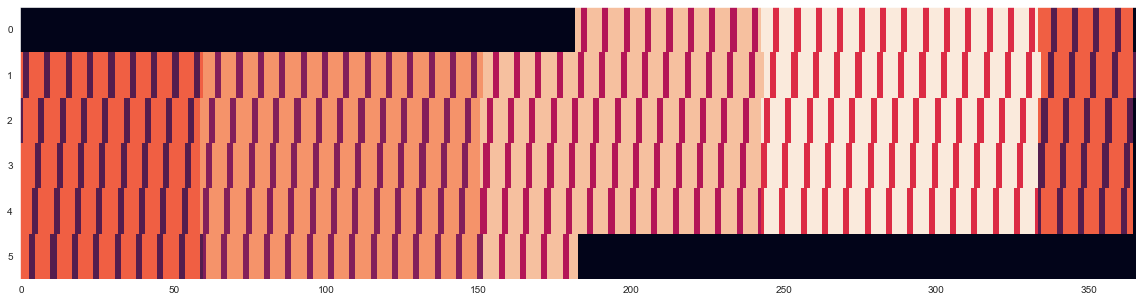

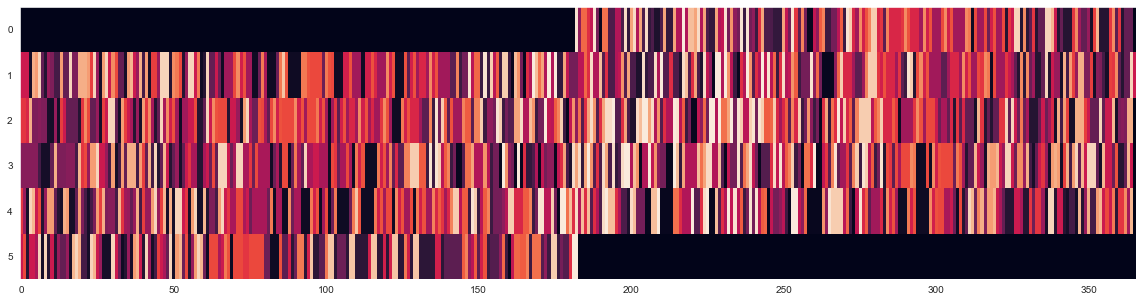

time: 251 ms


In [ ]:
day_type = df_date[["day type", "year", "day"]]
day_type = day_type.pivot(index = "year", columns = "day", values = "day type")
day_type.fillna(-1, inplace=True)

plt.figure(figsize=(20, 5))
plt.imshow(day_type, aspect='auto')

dset.fillna(-1, inplace=True)
plt.figure(figsize=(20, 5))
plt.imshow(dset, aspect='auto')
day_type